In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import h5py
import numpy as np
import json
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')

In [ ]:
from keras import optimizers
from keras import applications
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense, Input
from keras.regularizers import l2, l1
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, History
from keras import backend as K
from keras.utils.data_utils import get_file
from tensorflow.keras.utils import load_img

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print("Best Model:") 
    print_best_model_results(hist)

In [ ]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

In [ ]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, \
    ', val_accuracy:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

In [ ]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)
    
    model = VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict(generator, nb_train_samples // batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)
    
    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples // batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [ ]:
def train_top_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))
    
    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
    
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size,validation_data=(validation_data,validation_labels), callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f) 
        
    return model, fit.history

In [ ]:
def finetune_binary_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")
    
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    
    top_model.load_weights(top_model_weights_path)
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    for layer in model.layers[:25]:
        layer.trainable = False
    
    model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')
    
    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    
    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
        
    return model, fit.history 

In [ ]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='binary', shuffle=False)
    
    predictions = model.predict(generator, len(labels))
    
    pred_labels = [0 if i<0.5 else 1 for i in predictions]
    
    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

In [ ]:
#Defining Input
location = '/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1'
top_model_weights_path = location+'/top_model_weights.h5'
fine_tuned_model_path = location+'/ft_model.h5'

train_data_dir = location+'/train'
validation_data_dir = location+'/test'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = 3680
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = 920

img_width, img_height = 256,256
epochs = 50
#epochs = 1
batch_size = 16

In [ ]:
save_bottleneck_features()

58889256/58889256 [==============================] - 3s 0us/step
Found 3680 images belonging to 2 classes.
230/230 [==============================] - 2640s 11s/step
Found 920 images belonging to 2 classes.
58/58 [==============================] - 645s 11s/step


In [ ]:
d2_model1, d2_history1 = train_top_model()

Epoch 1/50
230/230 [==============================] - ETA: 0s - loss: 1.1910 - accuracy: 0.7837
Epoch 1: val_accuracy improved from -inf to 0.89565, saving model to /content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/top_model_weights.h5
230/230 [==============================] - 26s 109ms/step - loss: 1.1910 - accuracy: 0.7837 - val_loss: 0.2910 - val_accuracy: 0.8957
Epoch 2/50
230/230 [==============================] - ETA: 0s - loss: 0.4584 - accuracy: 0.8448
Epoch 2: val_accuracy improved from 0.89565 to 0.91087, saving model to /content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/top_model_weights.h5
230/230 [==============================] - 30s 130ms/step - loss: 0.4584 - accuracy: 0.8448 - val_loss: 0.2630 - val_accuracy: 0.9109
Epoch 3/50
230/230 [==============================] - ETA: 0s - loss: 0.3486 - accuracy: 0.8777
Epoch 3: val_accuracy did not improve from 0.91087
230/230 [==============================] - 19s 81ms/step -

Best Model:
epoch: 13 , val_accuracy: 0.926086962223053 , val_loss: 0.6139264702796936


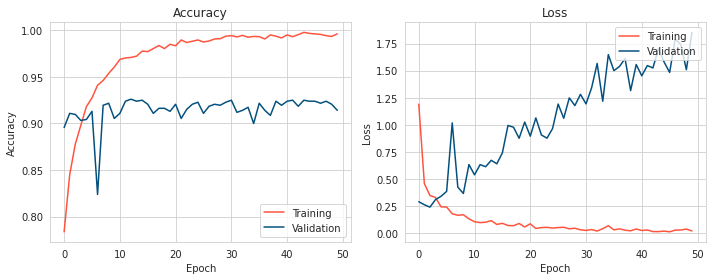

In [ ]:
plot_metrics(d2_history1)

In [ ]:
#Fine Tuning
ft_model, ft_history = finetune_binary_model()

Model loaded.


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 3680 images belonging to 2 classes.
Found 920 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


230/230 [==============================] - ETA: 0s - loss: 0.4785 - accuracy: 0.9239 
Epoch 1: val_accuracy improved from -inf to 0.92544, saving model to /content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/ft_model.h5
230/230 [==============================] - 3247s 14s/step - loss: 0.4785 - accuracy: 0.9239 - val_loss: 0.6193 - val_accuracy: 0.9254


In [ ]:
#plot_metrics(ft_history)

In [ ]:
#Load Model
ft_model = load_model(location+'/ft_model.h5')

In [ ]:
with open('/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/top_history.txt') as f:    
    top_history = json.load(f)

In [ ]:
with open('/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/ft_history.txt') as f:    
    ft_history = json.load(f)

In [ ]:
#plot_acc_metrics(top_history, ft_history)

In [ ]:
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

In [ ]:
cm = evaluate_binary_model(ft_model, validation_data_dir, validation_labels)

Found 920 images belonging to 2 classes.
58/58 [==============================] - 648s 11s/step

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       460
           1       0.94      0.91      0.92       460

    accuracy                           0.93       920
   macro avg       0.93      0.93      0.93       920
weighted avg       0.93      0.93      0.93       920




In [ ]:
heatmap_labels = ['Damaged', 'Whole']

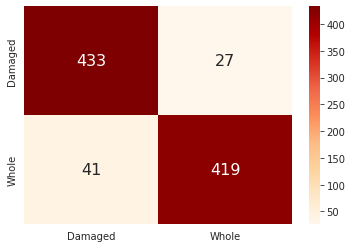

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels)

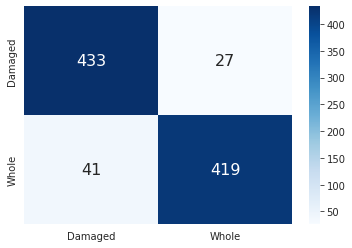

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels)

In [ ]:
#Pipe 2

In [ ]:
def pipe2(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    pred = model.predict(x)
    print("Validating that damage exists....")
    print(pred)
    if(pred[0][0]<=0.5):
        print("Validation complete - proceed to location and severity determination")
    else:
        print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print ("Hint: Try zooming in/out, using a different angle or different lighting")

In [ ]:
pipe2('https://i.ytimg.com/vi/4oV1klVPogY/maxresdefault.jpg', ft_model)

1/1 [==============================] - 1s 861ms/step
Validating that damage exists....
[[2.56354e-06]]
Validation complete - proceed to location and severity determination
